## Importing the Necessary Liabraries

In [1]:
# Importing reqiured Libraries

import nltk
import pandas as pd
from nltk.corpus import stopwords
from textblob import Word
from sklearn.preprocessing import LabelEncoder
from collections import Counter
import wordcloud
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

In [2]:
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf

In [3]:
import seaborn as sns
import re
import string

## Loading the dataset

In [4]:
# Loading the dataset
data = pd.read_csv("bbc-text.csv", )
data.head()

,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...


In [5]:
# Checking the shape of the dataset
data.shape

(2225, 2)

### Getting general information of the data

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2225 entries, 0 to 2224
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   category  2225 non-null   object
 1   text      2225 non-null   object
dtypes: object(2)
memory usage: 34.9+ KB


### # Checking the null values

In [7]:
# Checking the null values
data.isnull().sum()

category    0
text        0
dtype: int64

- We can see, there is no null values present in the dataset.

# Data Cleaning

### Checking for blank spaces, random characters in each column

In [8]:
search =[" ","?","-"," ?"," -","? ","- "," ? "," - ","NA","N/A"," NA"," N/A"]
for c in data:
    for s in search:
        print(f"{s} in {c} = ",end= " ")
        print((data[c] == s).sum())

  in category =  0
? in category =  0
- in category =  0
 ? in category =  0
 - in category =  0
?  in category =  0
-  in category =  0
 ?  in category =  0
 -  in category =  0
NA in category =  0
N/A in category =  0
 NA in category =  0
 N/A in category =  0
  in text =  0
? in text =  0
- in text =  0
 ? in text =  0
 - in text =  0
?  in text =  0
-  in text =  0
 ?  in text =  0
 -  in text =  0
NA in text =  0
N/A in text =  0
 NA in text =  0
 N/A in text =  0


- We can see,there are no blank spaces, random characters in the columns.

### Dropping duplicate observations

In [9]:
data.drop_duplicates(inplace = True) 

In [10]:
data.shape

(2126, 2)

### Percentage of Data Loss

In [11]:
data_loss = ((2225 - 2126)/2225*100)
print(data_loss,'%')

4.449438202247191 %


 - We can see, there is some duplicate row so I remove them from datasets.
 - We lost 4.44% data because those are duplicate in data.

In [12]:
# checking data balanced or not
data['category'].value_counts()

sport            504
business         503
politics         403
entertainment    369
tech             347
Name: category, dtype: int64

- We can see the label is not balanced wo we need balanced it.

In [13]:
# Checking text length
data['Stringlength'] = data['text'].str.len()
data.head()

,category,text,Stringlength
0,tech,tv future in the hands of viewers with home th...,4333
1,business,worldcom boss left books alone former worldc...,1842
2,sport,tigers wary of farrell gamble leicester say ...,1342
3,sport,yeading face newcastle in fa cup premiership s...,2176
4,entertainment,ocean s twelve raids box office ocean s twelve...,1579


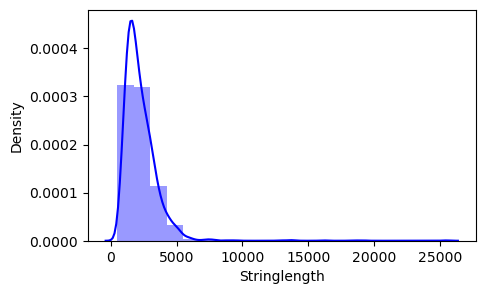

In [14]:
#Distribution of string length
plt.figure(figsize=(5,3))
sns.distplot(data.Stringlength, bins=20, color = 'blue')
plt.show()

- We can see, the text of news length is mostly lies 0 to 5000 word.

### Class Frequencies

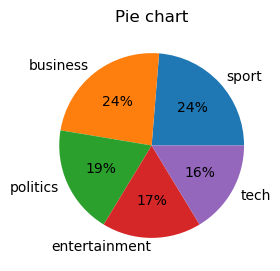

In [15]:
plt.figure(figsize=(3,3))
count_Class=pd.value_counts(data["category"], sort= True)
count_Class.plot(kind = 'pie',  autopct='%1.0f%%')
plt.title('Pie chart')
plt.ylabel('')
plt.show()

- We can see, business and sport news are higher in count and tech news are in lower in count.
- But data is imbalanced.

### Label Encoding

In [16]:
data.head()

,category,text,Stringlength
0,tech,tv future in the hands of viewers with home th...,4333
1,business,worldcom boss left books alone former worldc...,1842
2,sport,tigers wary of farrell gamble leicester say ...,1342
3,sport,yeading face newcastle in fa cup premiership s...,2176
4,entertainment,ocean s twelve raids box office ocean s twelve...,1579


In [17]:
# importing LabelEncoder
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()

In [18]:
# Changing the label encoding
df_cols=["category"] 
for i in df_cols:
    data[i]=le.fit_transform(data[i])

In [19]:
data.head()

,category,text,Stringlength
0,4,tv future in the hands of viewers with home th...,4333
1,0,worldcom boss left books alone former worldc...,1842
2,3,tigers wary of farrell gamble leicester say ...,1342
3,3,yeading face newcastle in fa cup premiership s...,2176
4,1,ocean s twelve raids box office ocean s twelve...,1579


## Data Pre-processing

In [20]:
# Convert all messages to lower case
data['text'] = data['text'].str.lower()

# Replace email addresses with 'email'
data['text'] = data['text'].str.replace(r'^.+@[^\.].*\.[a-z]{2,}$','emailaddress') 

# Replace URLs with 'webaddress'
data['text'] = data['text'].str.replace(r'^http\://[a-zA-Z0-9\-\.]+\.[a-zA-Z]{2,3}(/\S*)?$','webaddress')

# Replace money symbols with 'moneysymb'
data['text'] = data['text'].str.replace(r'£|\$', 'dollars') 

# Replacing 10 digit phone numbers with 'phonenumber'
data['text'] = data['text'].str.replace(r'^\(?[\d]{3}\)?[\s-]?[\d]{3}[\s-]?[\d]{4}$','phonenumber')

# Replace numbers with 'num'
data['text'] = data['text'].str.replace(r'\d+(\.\d+)?','num') 

# removing punctuations
data['text'] = data['text'].str.replace(r'[^\w\d\s]',' ') 

# removing underscore characters
data['text'] = data['text'].str.replace(r'[\_]',' ') 

# removing single characters
data['text'] = data['text'].str.replace(r'\s+[a-zA-Z]\s+', ' ') 

#removing whitespace between terms with a single space
data['text'] = data['text'].str.replace(r'\s+', ' ') 

# removing leading and trailing whitespace
data['text'] = data['text'].str.replace(r'^\s+|\s+?$', ' ') 

In [21]:
data.head()

,category,text,Stringlength
0,4,tv future in the hands of viewers with home th...,4333
1,0,worldcom boss left books alone former worldcom...,1842
2,3,tigers wary of farrell gamble leicester say th...,1342
3,3,yeading face newcastle in fa cup premiership s...,2176
4,1,ocean twelve raids box office ocean twelve the...,1579


In [22]:
import nltk
from nltk.corpus import stopwords,wordnet
from nltk.stem import WordNetLemmatizer

In [23]:
# Removing Stopword
stop_words = set(stopwords.words('english') + ['u','m', 'ü', 'ur', '4', '2', 'im', 'dont', 'doin',"u're", 'ure'])
data['text'] = data['text'].apply(lambda x: ' '.join(term for term in x.split() if term not in stop_words))

In [24]:
# Applying lemmatizer
lem=WordNetLemmatizer()
data['text'] = data['text'].apply(lambda x: ' '.join(lem.lemmatize(t) for t in x.split()))

In [25]:

from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.tokenize import word_tokenize, regexp_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

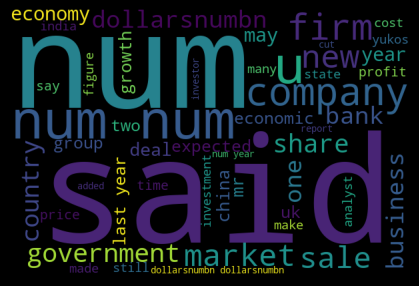

In [26]:
hams = data['text'][data['category']==0]
spam_cloud = WordCloud(width=600,height=400,background_color='black',max_words=50).generate(' '.join(hams))
plt.figure(figsize=(4,4),facecolor='k')
plt.imshow(spam_cloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

- we can see the business news contain the word like, Said, num, company economy which has most frequency

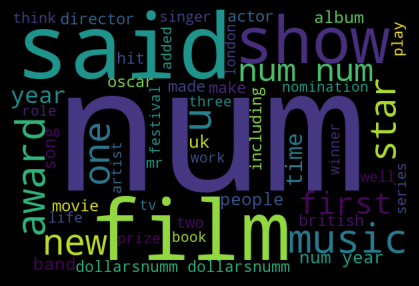

In [27]:
hams = data['text'][data['category']==1]
spam_cloud = WordCloud(width=600,height=400,background_color='black',max_words=50).generate(' '.join(hams))
plt.figure(figsize=(4,4),facecolor='k')
plt.imshow(spam_cloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

- Film, Num, music, award, show this are the words are contain in entertainment.

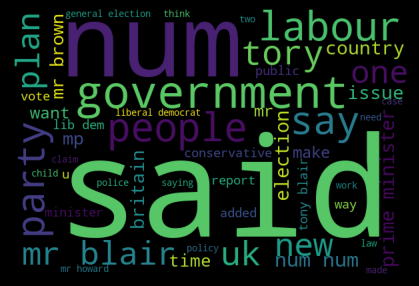

In [28]:
hams = data['text'][data['category']==2]
spam_cloud = WordCloud(width=600,height=400,background_color='black',max_words=50).generate(' '.join(hams))
plt.figure(figsize=(4,4),facecolor='k')
plt.imshow(spam_cloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

- goverment, labour, said, tory country these are the words are most frequently occured in politics.

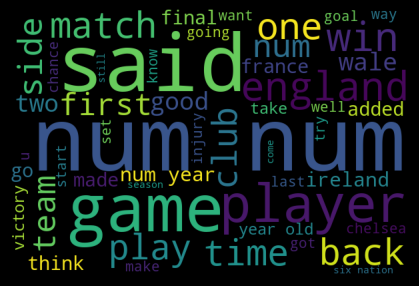

In [29]:
hams = data['text'][data['category']==3]
spam_cloud = WordCloud(width=600,height=400,background_color='black',max_words=50).generate(' '.join(hams))
plt.figure(figsize=(4,4),facecolor='k')
plt.imshow(spam_cloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

- Players, game, team, time, num, said these are words are most frequently occured in sport category.

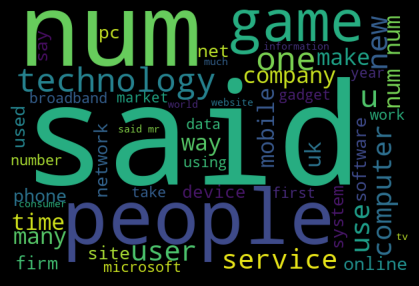

In [30]:
hams = data['text'][data['category']==4]
spam_cloud = WordCloud(width=600,height=400,background_color='black',max_words=50).generate(' '.join(hams))
plt.figure(figsize=(4,4),facecolor='k')
plt.imshow(spam_cloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

- Said, people, service, technology, computers these are the word occured in tech news.

In [31]:
# Removing the stringlength column 
data.drop(columns=['Stringlength' ],inplace = True)

In [32]:
data.head()

,category,text
0,4,tv future hand viewer home theatre system plas...
1,0,worldcom bos left book alone former worldcom b...
2,3,tiger wary farrell gamble leicester say rushed...
3,3,yeading face newcastle fa cup premiership side...
4,1,ocean twelve raid box office ocean twelve crim...


In [33]:
def cleaning(df, stop_words):
    # Converting to lowercase
    df['text'] = df['text'].apply(lambda x:
                        ' '.join(x.lower() for x in x.split()))
    
    # Replacing the digit/numbers
    
    df['text'] = df['text'].str.replace('d', '')
    
    # Removing stop words
    
    df['text'] = df['text'].apply(lambda x:
                        ' '.join(x for x in x.split() if x not in stop_words))
    
    # Lemmatization
    
    df['text'] = df['text'].apply(lambda x:
                        ' '.join([Word(x).lemmatize() for x in x.split()]))
    
    return df


stop_words = stopwords.words('english')

data = cleaning(data, stop_words)    
    

In [34]:
# tokenize the words or text
tokenizer = Tokenizer(num_words=500, split=' ')
tokenizer.fit_on_texts(data['text'].values)

# Padding the text
X = tokenizer.texts_to_sequences(data['text'].values)

In [35]:
X = tf.keras.preprocessing.sequence.pad_sequences(X)

## Model Building

In [36]:
# Model building
model = Sequential()
model.add(Embedding(500, 120, input_length = X.shape[1]))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(176, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(5, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 921, 120)          60000     
                                                                 
 spatial_dropout1d (SpatialD  (None, 921, 120)         0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 176)               209088    
                                                                 
 dense (Dense)               (None, 5)                 885       
                                                                 
Total params: 269,973
Trainable params: 269,973
Non-trainable params: 0
_________________________________________________________________
None


In [37]:
# Splitting the data into training and testing

y = pd.get_dummies(data['category'])
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state = 42)

In [38]:
# Converting to array
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

In [39]:
# Fit the model
model.fit(X_train, y_train, batch_size=32, epochs=7, verbose=1, validation_data=(X_test, y_test))

Epoch 1/7
47/47 [==============================] - 208s 4s/step - loss: 1.5701 - accuracy: 0.4005 - val_loss: 1.3838 - val_accuracy: 0.5094
Epoch 2/7
47/47 [==============================] - 244s 5s/step - loss: 1.0225 - accuracy: 0.6593 - val_loss: 0.7350 - val_accuracy: 0.7429
Epoch 3/7
47/47 [==============================] - 233s 5s/step - loss: 0.5471 - accuracy: 0.8414 - val_loss: 0.3871 - val_accuracy: 0.8981
Epoch 4/7
47/47 [==============================] - 235s 5s/step - loss: 0.2967 - accuracy: 0.9046 - val_loss: 0.2163 - val_accuracy: 0.9404
Epoch 5/7
47/47 [==============================] - 241s 5s/step - loss: 0.3984 - accuracy: 0.8931 - val_loss: 0.7577 - val_accuracy: 0.6834
Epoch 6/7
47/47 [==============================] - 249s 5s/step - loss: 0.4965 - accuracy: 0.8280 - val_loss: 0.3948 - val_accuracy: 0.9075
Epoch 7/7
47/47 [==============================] - 233s 5s/step - loss: 0.2179 - accuracy: 0.9456 - val_loss: 0.2459 - val_accuracy: 0.9404


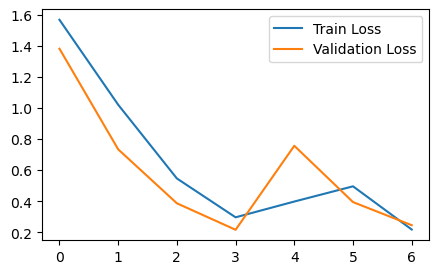

In [40]:
#  Ploting the loss 
plt.figure(figsize=(5,3))
plt.plot(model.history.history['loss'], label='Train Loss')
plt.plot(model.history.history['val_loss'], label='Validation Loss')
plt.legend()

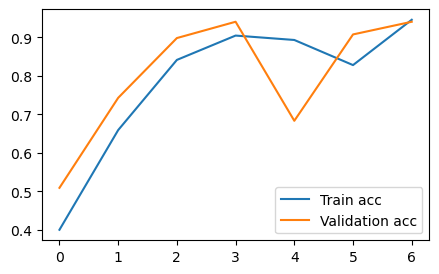

In [41]:
# Plot the accuracy
plt.figure(figsize=(5,3))
plt.plot(model.history.history['accuracy'], label='Train acc')
plt.plot(model.history.history['val_accuracy'], label='Validation acc')
plt.legend()